# Lindhard response

## Setup

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from tqdm import tqdm # optional, for progress bars in loops

In [2]:
# Fermi-Dirac distribtion
def fermi(E, mu, beta):
    return 1 / (np.exp(beta * (E - mu)) + 1)

# Tight binding bands
def Epx(kx, ky, t_sigma, t_pi, a):
    return -2 * t_sigma * np.cos(kx * a) - 2 * t_pi * np.cos(ky * a)

def Epy(kx, ky, t_sigma, t_pi, a):
    return -2 * t_sigma * np.cos(ky * a) - 2 * t_pi * np.cos(kx * a)

In [3]:
# LaTeX matplotlib settings
def latex_fig_param():
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Computer Modern']

# Default matplotlib - clear all settings
def default_fig_param():
    plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams['font.size'] = 20

In [4]:
# Electronic dispersion parameters
t_sigma = -2.0 # eV
t_pi = 0.2 # eV
fill = 2/3

a = 3.2341 # Angstrom
beta = 40 # room temperature

## Fig. S14

In [5]:
# Electronic bands and occupation calculation
# k-space
Nk = 300
k = np.linspace(-np.pi/a, np.pi/a, Nk, endpoint=False)
kx, ky = np.meshgrid(k, k)

# Dispersions
Ex = Epx(kx, ky, t_sigma, t_pi, a)
Ey = Epy(kx, ky, t_sigma, t_pi, a)

# Determine chemical potential
def f(mu, E, beta, fill):
    return np.sum(fermi(E, mu, beta)) / (Nk**2) - fill
mu_guess = 2.0
mu = fsolve(f, mu_guess, args=(Ex, beta, fill))[0]
print(f"Chemical potential: {mu:.3f}")

# Occupation - should be close to 2/3
Fx = fermi(Ex, mu, beta)
Fy = fermi(Ey, mu, beta)
print(f"Occupation p_x: {np.sum(Fx) / (Nk**2):.5f}")
print(f"Occupation p_y: {np.sum(Fy) / (Nk**2):.5f}")

Chemical potential: 1.993
Occupation p_x: 0.66667
Occupation p_y: 0.66667


In [6]:
# Lindhard function calculation
# q-space
C = 1               # conversion factor between Nk and Nq - resolution of q-grid compared to k-grid
Nq = Nk // C // 2   # q: 0 -> pi
#Nq = Nk // C        # q: 0 -> 2pi

# Broadening
eta = 1e-8

# Lindhard placeholder
Lx = np.zeros((Nq, Nq), dtype=complex)
Ly = np.zeros((Nq, Nq), dtype=complex)

# Loop over q-grid
for i in tqdm(range(Nq)):
    for j in range(Nq):
        # px, px
        num = np.roll(np.roll(Fx, i*C, axis=0), j*C, axis=1) - Fx
        den = np.roll(np.roll(Ex, i*C, axis=0), j*C, axis=1) - Ex + eta * 1j
        Lx[i, j] = np.sum(num / den) / (Nk**2)
        # py, py
        num = np.roll(np.roll(Fy, i*C, axis=0), j*C, axis=1) - Fy
        den = np.roll(np.roll(Ey, i*C, axis=0), j*C, axis=1) - Ey + eta * 1j
        Ly[i, j] = np.sum(num / den) / (Nk**2)

L = Lx + Ly

# Normalization
# Normalised against L(dq, dq) point as L(0, 0) is zero
L /= L[1, 1]

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:18<00:00,  8.22it/s]


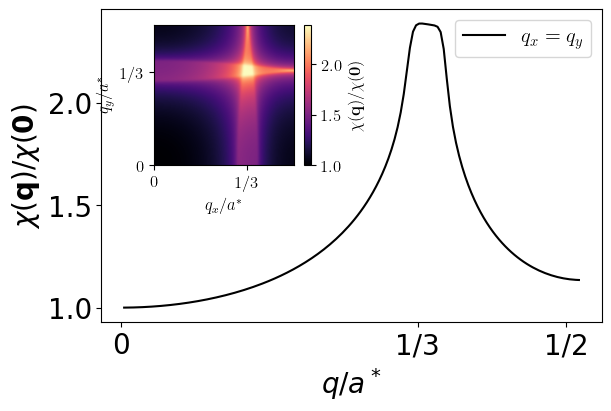

Value at peak: 2.386


In [7]:
# Plot setup
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
latex_fig_param()

# Main plot
plt.sca(ax1)
q = np.linspace(0, a / (2 * np.pi), Nq)
plt.plot(q[1:], np.diag(L.real)[1:], label=r'$q_x = q_y$', c='k')
plt.xlabel(r"$q / a^*$")
plt.ylabel(r'$\chi(\mathbf{q}) / \chi(\mathbf{0})$')
plt.xticks([0, 1/3, 1/2], ['0', '1/3', '1/2'])
plt.legend(loc='upper right', fontsize=15)

# Inset
# Position
left, bottom, width, height = [0.2, 0.6, 0.35, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
plt.sca(ax2)

# Colour normalization
norm = plt.Normalize(vmin=1, vmax=L.real.max())

# Extent and ticks
if Nq == Nk // C:
    extent = (0, 1, 0, 1)
    ticks = [0, 1/3, 2/3, 1]
    ticks_labels = ['0', '1/3', '2/3', '1']
elif Nq == Nk // C // 2:
    extent = (0, 1/2, 0, 1/2)
    ticks = [0, 1/3]
    ticks_labels = ['0', '1/3']
plt.yticks(ticks, ticks_labels, fontsize=12)
plt.xticks(ticks, ticks_labels, fontsize=12)

# Data plotting, colorbar
plt.imshow(L.real, extent=extent,
           norm=norm, cmap='magma', origin='lower')
cbar = plt.colorbar(shrink=1, label=r'$\chi(\mathbf{q}) / \chi(\mathbf{0})$')
cbar.set_label(r'$\chi(\mathbf{q}) / \chi(\mathbf{0})$', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Labels
plt.xlabel(r"$q_x / a^*$", fontsize=12)
plt.ylabel(r"$q_y / a^*$", fontsize=12)

plt.show()

print(f"Value at peak: {np.max(L.real):.3f}")

## Fig. 4d, 4e

First generate data using <code>lindhard_bilayer.py</code> script.

In [9]:
# Load data
t_al = 0.3
t_st = 0.1
lh_al = np.load(f"../data/lindhard_bilayer_aligned_{t_al}.npy")
lh_st = np.load(f"../data/lindhard_bilayer_staggered_{t_st}.npy")

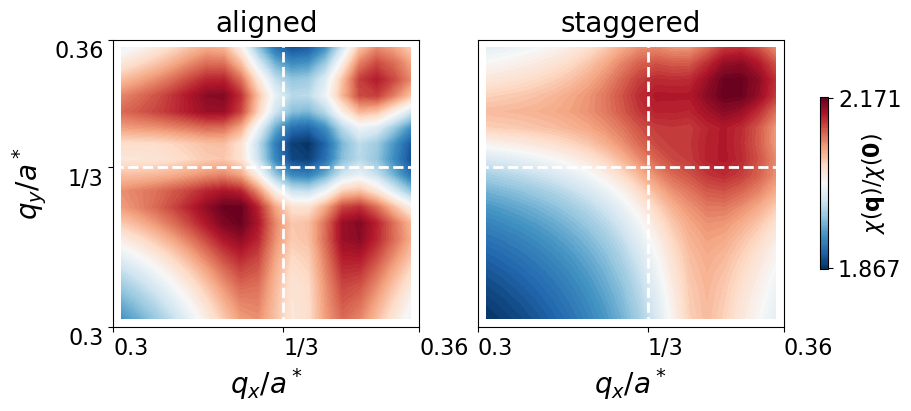

In [10]:
# Plot setup
default_fig_param()
fig, ax = plt.subplots(1, 2, figsize=(9, 4), layout='constrained')
# Axes limits
for i in range(2):
    ax[i].set_xlim(3/10, 9/25)
    ax[i].set_ylim(3/10, 9/25)

# Plot Lindhard functions
for i, data in enumerate([lh_al, lh_st]):
    # Data
    #z = ax[i].imshow(data.real, extent=(3/10, 9/25, 3/10, 9/25), cmap='RdBu_r', origin='lower', aspect='equal')
    z = ax[i].contourf(data.real, extent=(3/10, 9/25, 3/10, 9/25), cmap='RdBu_r', origin='lower', levels=100)

    # Line guides
    ax[i].hlines(1/3, 3/10, 9/25, ls='--', lw=2, color='white')
    ax[i].vlines(1/3, 3/10, 9/25, ls='--', lw=2, color='white')

    # Axes and labels
    ax[i].set_xlabel(r'$q_x / a^*$', fontsize=20)
    ax[i].set_xticks(np.array([3/10, 1/3, 9/25]), [0.3, '1/3', 0.36], fontsize=16, ha='left')

# Labels and ticks
ax[0].set_ylabel(r'$q_y / a^*$', fontsize=20)
ax[0].set_yticks(np.array([3/10, 1/3, 9/25]), [0.3, '1/3', 0.36], fontsize=16, va='top')
ax[1].set_yticks([])

# Colormap normalization and colorbar
vmin = min(lh_al.real.min(), lh_st.real.min())
vmax = max(lh_al.real.max(), lh_st.real.max())
cbar = fig.colorbar(z, ax=ax, shrink=0.6, location='right', pad=-0.02)
cbar.set_label(r'$\chi(\mathbf{q}) / \chi(\mathbf{0})$', fontsize=16, labelpad=-30)
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f"{vmin:.3f}", f"{vmax:.3f}"], fontsize=16)

# Titles
ax[0].set_title(f"aligned"  , fontsize=20, loc='center')
ax[1].set_title(f"staggered", fontsize=20, loc='center')

plt.show()